In [32]:
# Import libraries and the data set
import pandas as pd
import numpy as np
import sidetable
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
import DataScience

df = pd.read_csv('train.csv', index_col=['PassengerId'])
X_test = pd.read_csv('test.csv', index_col=['PassengerId'])

In [33]:
# Have a look at the first five rows
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Column __Name__ and __Ticket__ has nothing to do with predicting __Survived__, it will be dropped

In [34]:
df.drop(columns=['Name', 'Ticket'], inplace=True)
X_test.drop(columns=['Name', 'Ticket'], inplace=True)

In [35]:
# See the missing data in columns
df.stb.missing(style=True)

,missing,total,percent
Cabin,687,891,77.10%
Age,177,891,19.87%
Embarked,2,891,0.22%
Survived,0,891,0.00%
Pclass,0,891,0.00%
Sex,0,891,0.00%
SibSp,0,891,0.00%
Parch,0,891,0.00%
Fare,0,891,0.00%


As column __Cabin__ has 77% missing values, the column will be dropped.
<br>Column __Age__ can be imputed.
<br>As column __Embarked__ has 2 missing rows, the rows will be dropped.

In [36]:
# As Pclass includes fare, I will drop 'Fare'
df.drop(columns=['Cabin', 'Fare'], inplace=True, axis=1)
df.dropna(subset=['Embarked'], axis=0, inplace=True)

In [37]:
X_test.stb.missing(style=True)

,missing,total,percent
Cabin,327,418,78.23%
Age,86,418,20.57%
Fare,1,418,0.24%
Pclass,0,418,0.00%
Sex,0,418,0.00%
SibSp,0,418,0.00%
Parch,0,418,0.00%
Embarked,0,418,0.00%


As column __Cabin__ has 77% missing values, the column will be dropped.
<br>Column __Age__ can be imputed.
<br>As column __Fare__ has 2 missing rows, the rows will be dropped.

In [38]:
# As there are only two missing rows of column Embarked, I will drop the rows
X_test.drop(columns=['Cabin', 'Fare'], axis=1, inplace=True)
# X_test.dropna(subset=['Fare'], axis=0, inplace=True)

In [39]:
# Recheck the missing data in columns
df.stb.missing(style=True)

,missing,total,percent
Age,177,889,19.91%
Survived,0,889,0.00%
Pclass,0,889,0.00%
Sex,0,889,0.00%
SibSp,0,889,0.00%
Parch,0,889,0.00%
Embarked,0,889,0.00%


In [40]:
X_test.stb.missing(style=True)

,missing,total,percent
Age,86,418,20.57%
Pclass,0,418,0.00%
Sex,0,418,0.00%
SibSp,0,418,0.00%
Parch,0,418,0.00%
Embarked,0,418,0.00%


In [41]:
# Get X_train and y_train
y_train = df.Survived.copy()
X_train = df.drop(columns='Survived').copy()

In [42]:
# Retrive num_cols and cat_cols
num_cols = list(X_train._get_numeric_data().columns)
cat_cols = list(set(X_train.columns) - set(num_cols))

In [43]:
print(num_cols, cat_cols)

['Pclass', 'Age', 'SibSp', 'Parch'] ['Sex', 'Embarked']


In [44]:
# Impute cat_cols
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy='most_frequent')
X_train[cat_cols] = si.fit_transform(X_train[cat_cols])
X_test[cat_cols] = si.fit_transform(X_test[cat_cols])

In [45]:
# Encode cat_cols
X_train = pd.get_dummies(data=X_train, columns=cat_cols, drop_first=True)
X_test = pd.get_dummies(data=X_test, columns=cat_cols, drop_first=True)

In [46]:
# Have a look at the current columns
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 1 to 891
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      889 non-null    int64  
 1   Age         712 non-null    float64
 2   SibSp       889 non-null    int64  
 3   Parch       889 non-null    int64  
 4   Sex_male    889 non-null    uint8  
 5   Embarked_Q  889 non-null    uint8  
 6   Embarked_S  889 non-null    uint8  
dtypes: float64(1), int64(3), uint8(3)
memory usage: 37.3 KB


In [47]:
train_num_cols_to_be_imputed = X_train._get_numeric_data().columns[X_train.isnull().any()]
test_num_cols_to_be_imputed = X_test._get_numeric_data().columns[X_test.isnull().any()]

In [48]:
# This is the module I wrote included in folder 'package'
# Test for the best imputation algorithm for num_cols
DataScience.test_imputations(X_train, y_train, train_num_cols_to_be_imputed)

Imputing row 1/889 with 0 missing, elapsed time: 0.097
Imputing row 101/889 with 1 missing, elapsed time: 0.098
Imputing row 201/889 with 1 missing, elapsed time: 0.098
Imputing row 301/889 with 1 missing, elapsed time: 0.099
Imputing row 401/889 with 0 missing, elapsed time: 0.099
Imputing row 501/889 with 0 missing, elapsed time: 0.100
Imputing row 601/889 with 1 missing, elapsed time: 0.101
Imputing row 701/889 with 0 missing, elapsed time: 0.102
Imputing row 801/889 with 0 missing, elapsed time: 0.102
[KNN] Warning: 177/889 still missing after imputation, replacing with 0
               Mean    Median  Iterative       KNN
R_squared_adj   NaN  0.003753   0.004431 -0.001087


C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


We can see that Iterative yields the best Adjusted R Squared score

In [49]:
# # # Test for the best k neighors in KNN for num_cols
# DataScience.test_KNN_imputation(X_train, y_train, num_cols, range(2, 10))

In [50]:
# Impute num_cols
from fancyimpute import IterativeImputer
ii = IterativeImputer()
X_train[train_num_cols_to_be_imputed] = ii.fit_transform(X_train[train_num_cols_to_be_imputed])
X_test[test_num_cols_to_be_imputed] = ii.fit_transform(X_test[test_num_cols_to_be_imputed])

In [51]:
# Scale num_cols
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
num_scaled = sc.fit_transform(X_train[train_num_cols_to_be_imputed])
X_train[train_num_cols_to_be_imputed] = pd.DataFrame(num_scaled, index=X_train.index, columns=train_num_cols_to_be_imputed)
num_scaled = sc.fit_transform(X_test[test_num_cols_to_be_imputed])
X_test[test_num_cols_to_be_imputed] = pd.DataFrame(num_scaled, index=X_test.index, columns=test_num_cols_to_be_imputed)

In [52]:
num_cols

['Pclass', 'Age', 'SibSp', 'Parch']

In [53]:
# Verify X_train
X_train.head()

,Pclass,Age,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,
1,3,-0.589620,1,0,1,0,1
2,1,0.644848,1,0,0,0,0
3,3,-0.281003,0,0,0,0,1
4,1,0.413385,1,0,0,0,1
5,3,0.413385,0,0,1,0,1


In [54]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import StratifiedKFold

# parameters = {
#         'n_estimators': [200, 500, 700],
#         'max_features': ['auto', 'sqrt', 'log2'],
#         'max_depth' : [4,5,6,7,8],
#         'criterion' :['gini', 'entropy']
#              }
# rfc = RandomForestClassifier(random_state=1)
# xgb_grid = GridSearchCV(estimator=rfc,
#                         param_grid=parameters,
#                         cv = StratifiedKFold(5),
#                         verbose=True,
#                         n_jobs = -1)
# # Try fitting training data sets with all parameters
# xgb_grid.fit(X_train,y_train)

# # Print the best parameters
# print(xgb_grid.best_params_)

# # Fit the training tests using the best parameters
# gbm = RandomForestClassifier(**xgb_grid.best_params_, random_state=1)
# gbm.fit(X_train,y_train)

# # Get the predicted values
# predictions = gbm.predict(X_test_copy)

In [55]:
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBClassifier
# from sklearn.model_selection import StratifiedKFold
# parameters = {'objective':['reg:linear'],
#               'learning_rate': [0.1, 0.2], #so called `eta` value
#               'gamma': [0.5, 1, 1.5, 2, 5],
#               'subsample': [0.6, 0.8, 1.0],
#               'min_child_weight': [1, 5, 10],
#               'n_estimators': [500],
#                 'colsample_bytree': [0.6, 0.8, 1.0],
#                 'max_depth': [3, 4, 5],
#                 'reg_alpha': [1.1, 1.2, 1.3],
#                 'reg_lambda': [1.1, 1.2, 1.3],
#                 'subsample': [0.7, 0.8, 0.9]
#              }

# xgb_grid = GridSearchCV(XGBClassifier(random_state=1),
#                         parameters,
#                         cv = StratifiedKFold(),
#                         n_jobs = -1,
#                         verbose=True)

# # Try fitting training data sets with all parameters
# xgb_grid.fit(X_train,y_train)

# # Print the best parameters
# print(xgb_grid.best_params_)

# #Fit the training tests using the best parameters
# gbm = XGBClassifier(**xgb_grid.best_params_, random_state=1)
# gbm.fit(X_train,y_train)

# # Print the accuracy of prediction
# predictions = gbm.predict(X_test_copy)

In [56]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier

decisiontree = DecisionTreeClassifier()
# Create lists of parameter for Decision Tree Classifier
parameters = {'max_features': ['auto', 'sqrt', 'log2'],
          'min_samples_split': range(2, 16), 
          'min_samples_leaf': range(12),
          'random_state':[1]}

# Create a grid search object
grid_search = GridSearchCV(estimator=decisiontree, param_grid=parameters, scoring='accuracy', cv=StratifiedKFold(), n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train,y_train)

# View The Best Parameters
print(grid_search.best_params_)

{'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'random_state': 1}


## Find the best ccp_alpha

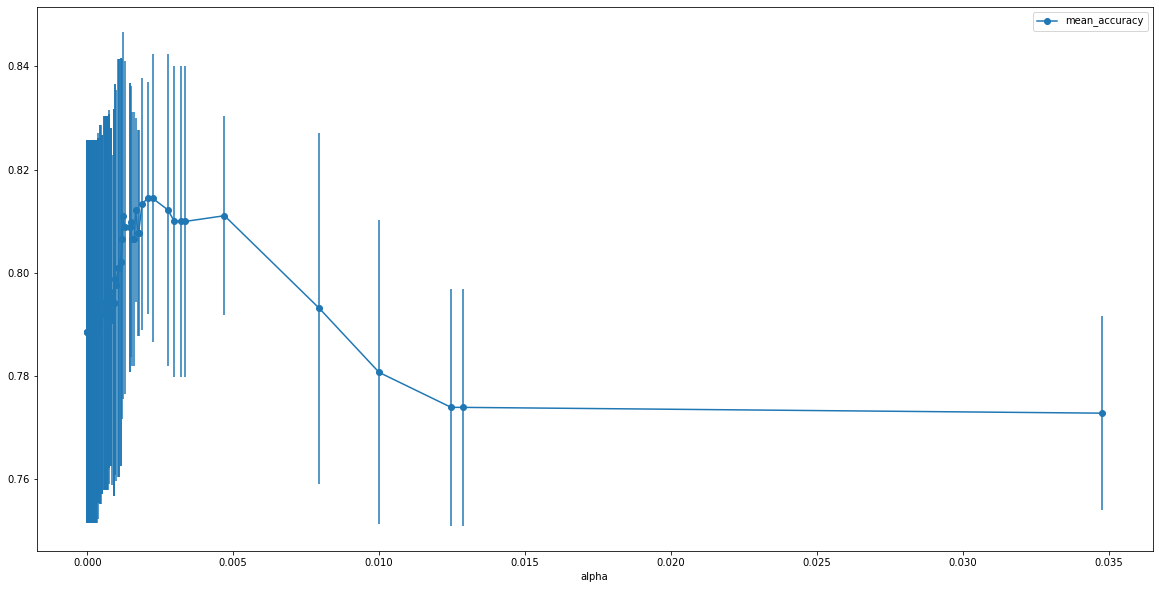

In [57]:
path = decisiontree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

alpha_loop_values = []
for ccp_alpha in ccp_alphas:
    model = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    scores = cross_val_score(model, X_train, y_train, cv=StratifiedKFold())
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha', 'mean_accuracy', 'std'])
alpha_results.plot(x='alpha', y='mean_accuracy', yerr='std', marker='o', figsize=(20, 10))
plt.show()

We can see that the best alpha is between 0.003 and 0.005

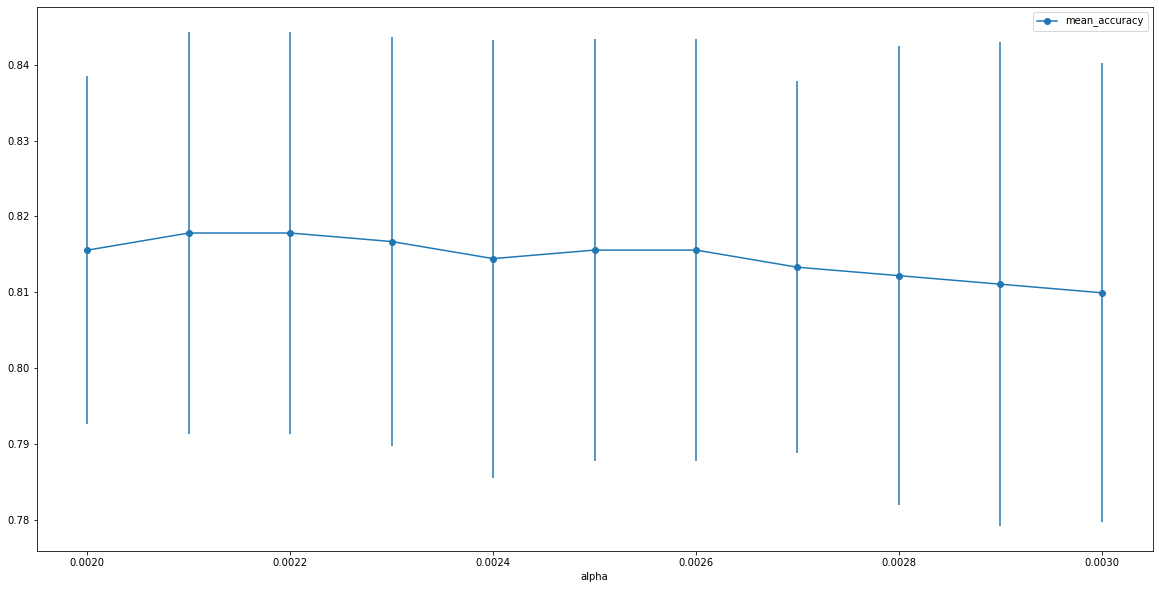

In [58]:
ccp_alphas = np.linspace(0.002, 0.003, 11)
alpha_loop_values = []
for ccp_alpha in ccp_alphas:
    model = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    scores = cross_val_score(model, X_train, y_train, cv=StratifiedKFold())
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha', 'mean_accuracy', 'std'])
alpha_results.plot(x='alpha', y='mean_accuracy', yerr='std', marker='o', figsize=(20, 10))
plt.show()

We can see that ideal_cpp_alpha = 0.0022

## Rebuild the Tree model using the best parameters

In [62]:
best_search = DecisionTreeClassifier(**grid_search.best_params_, ccp_alpha=0.0022)
best_search.fit(X_train, y_train)
predictions = best_search.predict(X_test)

In [63]:
# Get the index of the predicted table
index = X_test.index
predictions = pd.DataFrame(predictions, columns=['Survived'], index=index)

# saving the DataFrame as a CSV file 
csv_data = predictions.to_csv('Predictions.csv', index = True) 

In [64]:
# Verify the prediction's format
print(predictions.head())

             Survived
PassengerId          
892                 0
893                 0
894                 0
895                 0
896                 0
